$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## An introduction to smoothing

Smoothing is a process by which data points are averaged with their neighbors
in a series, such as a time series, or image. This (usually) has the effect of
blurring the sharp edges in the smoothed data.  Smoothing is sometimes
referred to as filtering, because smoothing has the effect of suppressing high
frequency signal and enhancing low frequency signal. There are many different
methods of smoothing, but here we discuss smoothing with a Gaussian kernel. We
hope we will succeed in explaining this phrase in the explanation below.

### Some example data for smoothing

First we load and configure the libraries we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Make numpy print 4 significant digits for prettiness
np.set_printoptions(precision=4, suppress=True)
np.random.seed(5) # To get predictable random numbers

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from sklearn import datasets  # to retrieve the iris Dataset
import pandas as pd  # to load the dataframe
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps#float32

Here is a set of data, made out of random numbers, that we will use as a
pretend time series, or a single line of data from one plane of an
image.

(336, 115379)
(336, 115379)


<BarContainer object of 1000 artists>

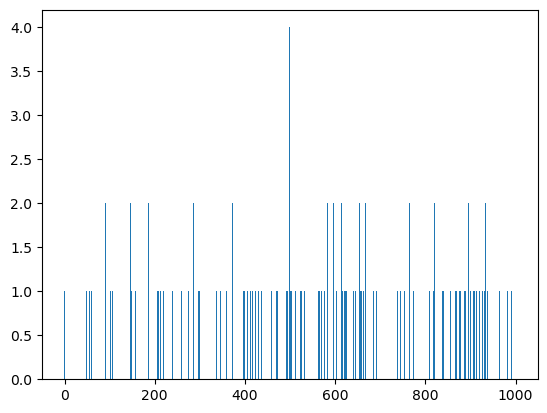

In [30]:
# Load spike data
spike_data = np.load('data/spikes_v1_clean.npy')                      
spike_data_t = spike_data[:,0:999]
print(np.shape(spike_data))

# short time span
t = np.shape(spike_data)[1]
n = np.shape(spike_data)[0]

scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(spike_data)) #scaling the data
print(scaled_data.shape)



# scaled data or non scaled data
length = 1000
nn = 1
y_spike_full = pd.DataFrame.to_numpy(scaled_data)

y_spike = spike_data[nn-1,0:length]
t_full = np.linspace(1, t, t)
t_x = np.arange(length)
n_y = np.shape(y_spike)[0]

plt.bar(t_x,y_spike)
#print(t_x)
#print(y_spike[nn-1,0:length])

# The Gaussian kernel

The ‘kernel’ for smoothing, defines the shape of the function that is
used to take the average of the neighboring points. A Gaussian kernel
is a kernel with the shape of a Gaussian (normal distribution) curve.
Here is a standard Gaussian, with a mean of 0 and a $\sigma$ (=population
standard deviation) of 1.

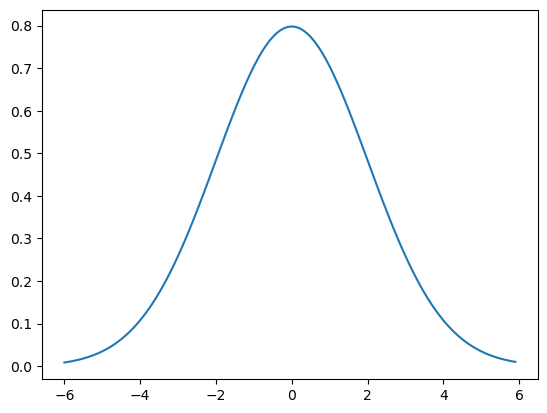

In [47]:
x = np.arange(-6, 6, 0.1) # x from -6 to 6 in steps of 0.1
sigma = 2
y = 1 / (sigma*np.sqrt(2 * np.pi)) * np.exp(-x ** 2 / 2*sigma**2)
plt.plot(x, y)

In the standard statistical way, we have defined the width of the Gaussian
shape in terms of $\sigma$. However, when the Gaussian is used for smoothing,
it is common for imagers to describe the width of the Gaussian with another
related measure, the Full Width at Half Maximum (FWHM).

The FWHM is the width of the kernel, at half of the maximum of the
height of the Gaussian. Thus, for the standard Gaussian above, the
maximum height is ~0.4.  The width of the kernel at 0.2 (on the Y axis) is the
FWHM. As x = -1.175 and 1.175 when y = 0.2, the FWHM is roughly 2.35.

The FWHM is related to sigma by the following formulae (in Python):

In [48]:
def sigma2fwhm(sigma):
    return sigma * np.sqrt(8 * np.log(2))

In [49]:
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

In our case:

In [50]:
sigma2fwhm(sigma)

1.1774100225154747

# Smoothing with the kernel

The basic process of smoothing is very simple. We proceed through the
data point by point. For each data point we generate a new value that is
some function of the original value at that point and the surrounding
data points.With Gaussian smoothing, the function that is used is our
Gaussian curve..

So, let us say that we are generating the new, smoothed value for the
14th value in our example data set. We are using a Gaussian with FWHM of
4 units on the x axis. To generate the Gaussian kernel average for this
14th data point, we first move the Gaussian shape to have its center at
13 on the x axis (13 is the 14th value because the first value is 0). In order
to make sure that we don’t do an overall scaling of the values after
smoothing, we divide the values in the Gaussian curve by the total area under
the curve, so that the values add up to one:

<BarContainer object of 1000 artists>

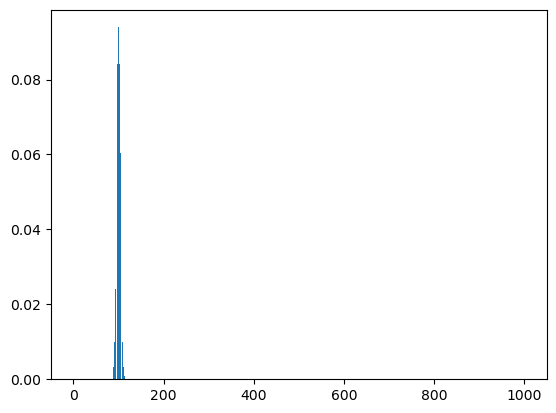

In [63]:
#
FWHM = 20
sigma = fwhm2sigma(FWHM)
x_position = 100 # 14th point
kernel_at_pos_n = np.exp(-(t_x - x_position) ** 2 / (2 * sigma ** 2))
kernel_at_pos_n = kernel_at_pos_n / sum(kernel_at_pos_n)
plt.bar(t_x, kernel_at_pos_n)

In fact the Gaussian values for the 12th through 16th data points are:

and the data values for the same points are:

We then multiply the Gaussian kernel (weight) values by the values of our
data, and sum the results to get the new smoothed value for point 13:

In [69]:
#
y_spike_by_weight = y_spike * kernel_at_pos_n # element-wise multiplication
new_val_spike = sum(y_spike_by_weight)
new_val

-0.3479685901184573

We store this new smoothed value for future use, and move on, to x = 14,
and repeat the process, with the Gaussian kernel now centered over 14.  If we
do this for each point, we eventually get the smoothed version of our original
data. Here is a very inefficient but simple way of doing this:

<BarContainer object of 1000 artists>

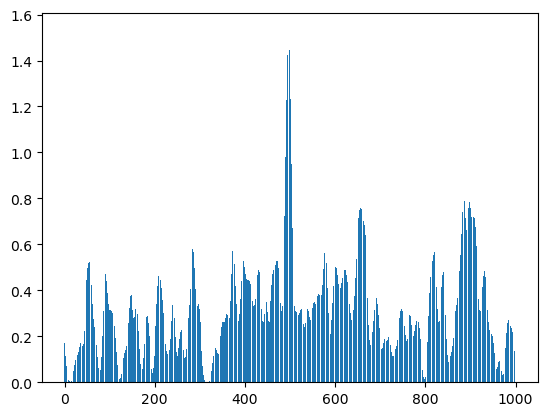

In [71]:
#
smoothed_vals_spike = np.zeros(y_spike.shape)

for x_position in t_x:
    #print(x_position)
    kernel = np.exp(-(t_x - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_vals_spike[x_position] = sum(y_spike * kernel)
plt.bar(t_x, smoothed_vals_spike)

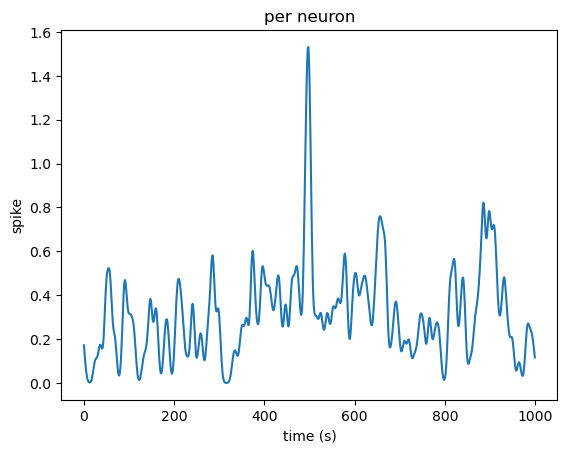

In [72]:
fig, ax = plt.subplots()
ax.plot(smoothed_vals_spike)

ax.set(xlabel='time (s)', ylabel='spike',
       title='per neuron')
plt.show()